In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib
plt.rcParams.update({
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15,
                     "savefig.dpi": 400,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )

### Load all x and y values 

In [2]:
folder_name = '../data_AP_SPHERE/'
metric_name = 'AP_SPHERE'
iteration = 8
for i in range(1,iteration):
    s_array = np.load(folder_name + str(i) + '/spectra.npy')
    obj = np.load(folder_name + str(i) + '/new_obj.npy')
    if i == 1:
        s_array_all = s_array
        obj_all = obj
    else:
        s_array_all = np.vstack((s_array_all, s_array))
        obj_all = np.vstack((obj_all, obj))
all_spectra = s_array_all

In [3]:
all_x = np.load(folder_name + str(iteration-1) + '/train_x.npy') #All x_values from 0th iteration to iteration-1 

In [4]:
array = np.hstack((obj_all, all_x, all_spectra))

In [5]:
sorted_array = array[np.argsort(array[:, 0])]

### Find the best sample in each iteration 

In [6]:
best_score = []
wavelength = np.load(folder_name + '1/wavelengths.npy')
for i in range(1,iteration):
    #s_array = np.load(folder_name + str(i) + '/spectra.npy')
    s_array = pd.read_excel(folder_name + str(i-1) + '.xlsx').values
    obj = np.load(folder_name + str(i) + '/new_obj.npy')
    x = np.load(folder_name + str(i) + '/new_x.npy')
    array = np.hstack((obj, x, s_array[:,1:].T))
    sorted_array = array[np.argsort(array[:, 0])]
    best_x = sorted_array[-1,1:3]
    best_y = sorted_array[-1,3:]
    best_score.append(sorted_array[-1,0])
    if i == 1:
        all_best_x = best_x
        all_best_y = best_y
    else:
        all_best_x = np.vstack((all_best_x, best_x))
        all_best_y = np.vstack((all_best_y, best_y))

### Plot data 

In [7]:
target = pd.read_excel('Target_SPHERE.xlsx')
target = np.asarray(target)
target_spectra = target[:,1].reshape(-1,1)

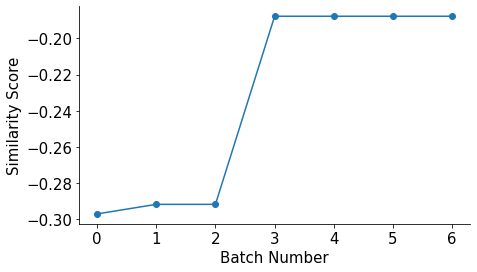

In [8]:
cumulative_best = [best_score[0]]
for i in range(1, len(best_score)):
    if best_score[i] > cumulative_best[i-1]:
        cumulative_best.append(best_score[i])
    else:
        cumulative_best.append(cumulative_best[i-1])
itr = np.linspace(0,iteration -2, iteration -1)
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(itr, cumulative_best, '-o')
plt.xlabel('Batch Number', fontsize = 15)
plt.ylabel('Similarity Score', fontsize = 15)
plt.savefig('../figures/' + metric_name + 'cumulative_best.png')

In [9]:
all_x = all_x*140 + 10

In [10]:
confidence = np.load(folder_name + 'confidence.npy')
opt_x = np.load(folder_name + 'opt_x.npy')
posterior_mean = np.load(folder_name + 'posterior_mean.npy')
lower = np.load(folder_name + 'lower.npy')
upper = np.load(folder_name + 'upper.npy')

INFO: Using numpy backend
/mnt/c/Users/Huat Thart/Desktop/HEAD/head/designspace.py:63: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points = np.vstack(map(np.ravel, self.mesh)).T


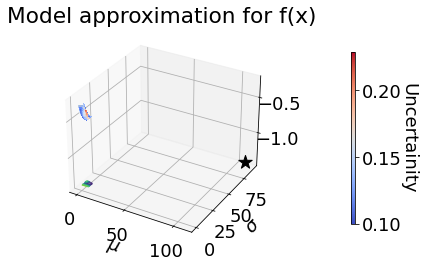

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm
from matplotlib.colors import Normalize
import head
import torch
plt.rcParams.update({
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15,
                     "savefig.dpi": 400,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )
font = {'size'   : 18}

matplotlib.rc('font', **font)
target = [110,90]
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

bounds = [[0,7.38],[0,7.27]]
fig, ax = plt.subplots(subplot_kw={'projection':'3d'})

ax.set_xlabel(r'$\mu$', fontsize=18)
ax.set_ylabel(r'$\sigma$', fontsize=18)
with torch.no_grad():
    num_grid_spacing = 20
    mu_grid = np.linspace(*bounds[0], num=num_grid_spacing)
    sig_grid = np.linspace(*bounds[1], num=num_grid_spacing)
    test_x = head.Grid(mu_grid, sig_grid).points
    #posterior = optim.model.posterior(optim.inp.transform(torch.tensor(test_x).to(**tkwargs)))
    #posterior_mean = posterior.mean.cpu().numpy()
    #lower, upper = posterior.mvn.confidence_region()
    confidence = np.abs((lower-upper))
    ls = LightSource(0, 0)
    rgb = ls.shade(confidence.reshape(num_grid_spacing,num_grid_spacing), 
                   cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')
    XX, YY = np.meshgrid(mu_grid, sig_grid)
    Z = posterior_mean.reshape(num_grid_spacing,num_grid_spacing)
    sc = ax.plot_surface(XX, YY, Z, 
                    rstride=1, cstride=1, 
                    facecolors=rgb,
                    linewidth=0, antialiased=False, shade=False)
    ax.contour(XX, YY, Z, zdir='z', offset=-1.4, cmap=cm.viridis)
    ax.scatter(target[0], target[1], zs=-1.4, zdir='z', marker='*', s=200,color='k')
    ax.set_title('Model approximation for f(x)')
    cmap = cm.get_cmap('coolwarm')
    norm = Normalize(vmin=confidence.min(), vmax = confidence.max())
    cax = plt.axes([0.95, 0.2, 0.01, 0.6])        
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.ax.set_ylabel('Uncertainity', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    

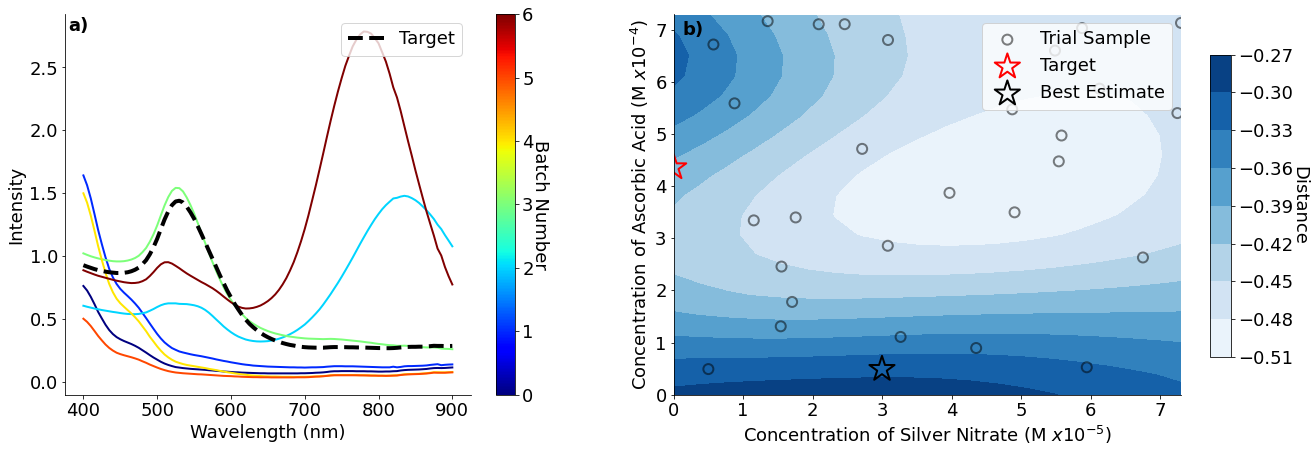

In [12]:
AG_x = all_best_x[:,0]*0.00064/1300
AA_x = all_best_x[:,1]*0.00630/1300
all_best_conc_x = np.hstack((AG_x.reshape(-1,1), AA_x.reshape(-1,1)))
AG_x = all_x[:,0]*0.00064/1300*10**5
AA_x = all_x[:,1]*0.00630/1300*10**4
opt_x_AG = opt_x[0]*0.00064/1300*10**5
opt_x_AA = opt_x[1]*0.00630/1300*10**4
conc_x = np.hstack((AG_x.reshape(-1,1), AA_x.reshape(-1,1)))
batches = iteration-1
samples_in_batch = 4
cmap = cm.get_cmap('winter')
norm = matplotlib.colors.Normalize(vmin=0, vmax = batches-1)
fig, ax = plt.subplots(figsize = (20,7), ncols = 2)
im = ax[1].contourf(XX, YY, Z, cmap=cm.Blues)
#for i in range(batches):
    #for j in range(samples_in_batch):
        #ax[1].scatter(conc_x[i*samples_in_batch+j,0]*10**5, conc_x[i*samples_in_batch+j,1]*10**4, fc='none', lw=2.0, marker = 'o', alpha=0.5, s = 100, color = 'k') #color = cmap(norm(i)), s = 100)
ax[1].scatter(conc_x[:,0],conc_x[:,1], fc='none', lw=2.0, marker = 'o', alpha=0.5, s = 100, color = 'k', label = 'Trial Sample')
ax[1].scatter(0,4.36, label = 'Target', marker='*', facecolors='none', color='red', lw=2.0, s = 700)
ax[1].scatter(opt_x_AG, opt_x_AA, marker='*', s=700,lw=2.0,fc='none',color='k', label= 'Best Estimate')
ax[1].set_xlim([0,7.3])
ax[1].set_ylim([0,7.3])
ax[1].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')
ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel(r'$\sigma$')
ax[1].set_xlabel('Concentration of Silver Nitrate (M $ x 10^{-5}$)', fontsize = 18)
ax[1].set_ylabel('Concentration of Ascorbic Acid (M $ x 10^{-4}$)', fontsize = 18)

cmap = cm.get_cmap('winter')
norm = Normalize(vmin=confidence.min(), vmax = confidence.max())
cax = plt.axes([0.92, 0.2, 0.015, 0.6])        
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Distance', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

cmap = cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax = batches-1)
for i in range(iteration-1):
    ax[0].plot(wavelength, all_best_y[i,:], color = cmap(norm(i)), linewidth = 2)
ax[0].plot(wavelength, target_spectra.reshape(-1,1), linewidth = 4, color = 'k', label = 'Target', ls='--',)
ax[0].set_xlabel('Wavelength (nm)',fontsize = 18)
ax[0].set_ylabel('Intensity',fontsize = 18)
#ax[0].set_ylim([0.00,1.5])
ax[0].legend(loc = 'upper right')
ax[0].text(380,np.max(all_best_y), 'a)', fontsize = 18, fontweight='bold')
ax[1].text(0.12,6.9, 'b)', fontsize = 18, fontweight='bold')
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[0])
cbar.ax.set_ylabel('Batch Number', rotation=270, fontsize = 18)
cbar.ax.get_yaxis().labelpad = 15
plt.savefig('../figures/' + metric_name + 'double_plots.png')

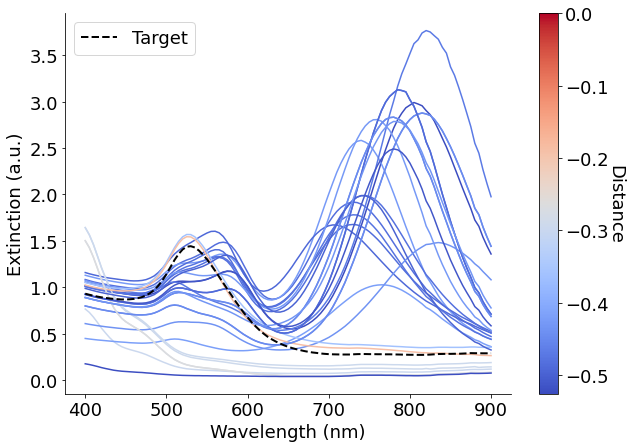

In [13]:
train_obj = np.load(folder_name + str(iteration-1) + '/train_obj.npy').squeeze()
cmap = cm.get_cmap('coolwarm')
norm = matplotlib.colors.Normalize(vmin=min(train_obj), vmax = 0)
fig, ax = plt.subplots(figsize = (10,7))
for i in range(len(train_obj)):
    ax.plot(wavelength, all_spectra[i,:],
            color=cmap(norm(train_obj[i])))
ax.plot(wavelength, target_spectra.reshape(-1,1),
        linewidth = 2.0,
        ls='--',
        color = 'k',
        label = 'Target')
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.ax.set_ylabel('Distance', rotation=270,fontsize = 18)
cbar.ax.get_yaxis().labelpad = 15
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Extinction (a.u.)')
plt.savefig('../figures/' + metric_name + '_distance_plot.png')
plt.legend()
plt.show()